In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import datetime

sns.set_theme("notebook")
%matplotlib inline

### Chargement des données, séparé par machine

In [2]:
df = pd.read_csv("../../data/prepared_data/dataset.csv")

df_by_machine = df.groupby("machineID")

##### Age et nombre de défaillances par type de machine

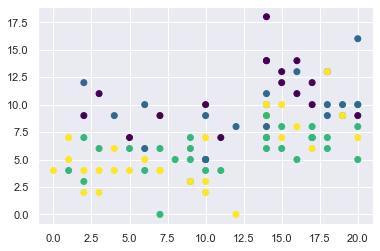

In [3]:
data=[]
ages=[]
modeles =[]
for i in range(1,100):
    df_machine = df_by_machine.get_group(i)
    ages.append(df_machine["age"].values[0])
    modeles.append(int(df_machine["model"].values[0][5]))
    data.append(df_machine["total_failure"].sum())
plt.scatter(ages,data,c=modeles,cmap='viridis')

### Calcul des corrélations en télémétry

In [4]:
telemetry_df=df[['volt_mean', 'volt_std', 'rotate_mean', 'rotate_std','pressure_mean', 'pressure_std', 'vibration_mean', 'vibration_std','comp1', 'comp2', 'comp3', 'comp4', 'total_failure']]

<AxesSubplot:>

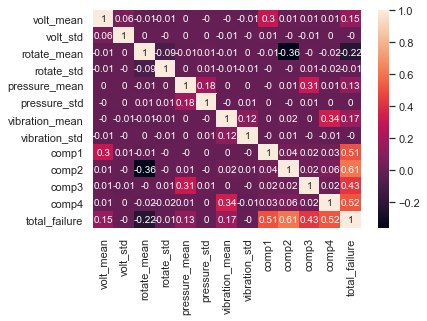

In [5]:
matrix = telemetry_df.corr().round(2)
sns.heatmap(matrix, annot=True)

On observe les corrélations suivantes entre la télémétrie et les défaillances: 
    - Volt_mean avec Comp1, 
    - Rotate_mean avec Comp2 (négativement), 
    - Pressure_mean avec Comp3,
    - Vibration_mean avec Comp4

On observe les corrélations suivantes entre les erreurs et les défaillances: - Error1 avec Comp1, - Error2 et Error3 avec Comp2 , - Error4 avec Comp3, - Error5 avec Comp4

### Visualisation des corrélations détectées

Coloriage par defaillance, représentation par age du composant

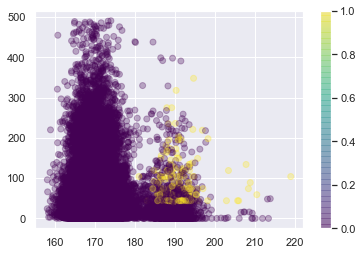

In [6]:
plt.scatter(df['volt_mean'],df['comp1_delay'],c=df['comp1'],cmap='viridis', alpha=0.3)
plt.colorbar()

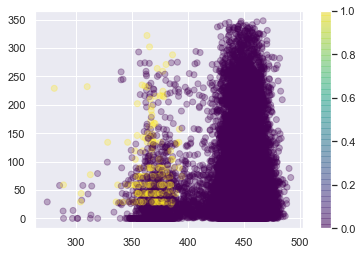

In [7]:
plt.scatter(df['rotate_mean'],df['comp2_delay'],c=df['comp2'],cmap='viridis', alpha=0.3)
plt.colorbar()

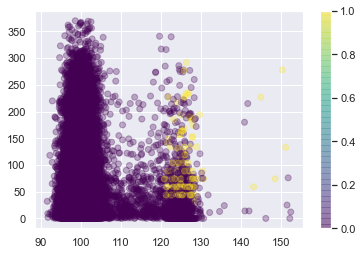

In [8]:
plt.scatter(df['pressure_mean'],df['comp3_delay'],c=df['comp3'],cmap='viridis', alpha=0.3)
plt.colorbar()

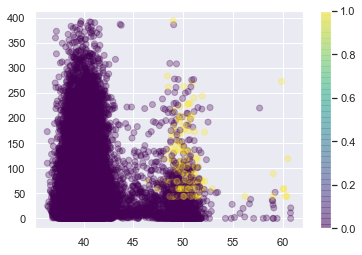

In [9]:
plt.scatter(df['vibration_mean'],df['comp4_delay'],c=df['comp4'],cmap='viridis', alpha=0.3)
plt.colorbar()

### Calcul des corrélations avec les erreurs

On va afficher une autre matrice de corrélation: entre les erreurs détectées et les défaillances

In [10]:
errors_df=df[['error1', 'error2', 'error3', 'error4','error5', 'comp1', 'comp2', 'comp3', 'comp4', 'total_failure']]

<AxesSubplot:>

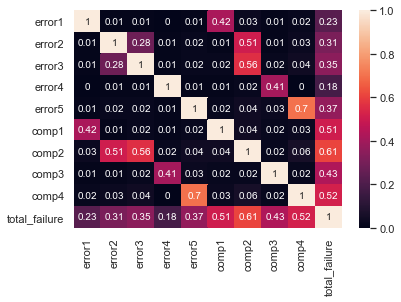

In [11]:
matrix = errors_df.corr().round(2)
sns.heatmap(matrix, annot=True)

On observe les corrélations suivantes entre les erreurs et les défaillances: - Error1 avec Comp1, - Error2 et Error3 avec Comp2 , - Error4 avec Comp3, - Error5 avec Comp4

On ajoute ça dans nos graphes précédents

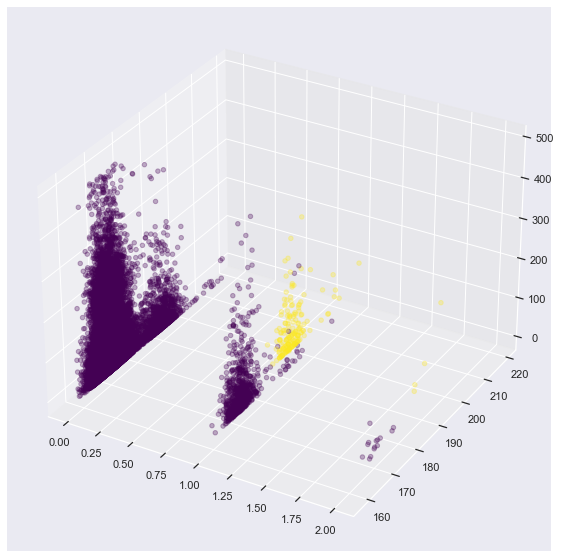

In [12]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(df['error1'],df['volt_mean'],df['comp1_delay'],c=df['comp1'],cmap='viridis', alpha=0.3)

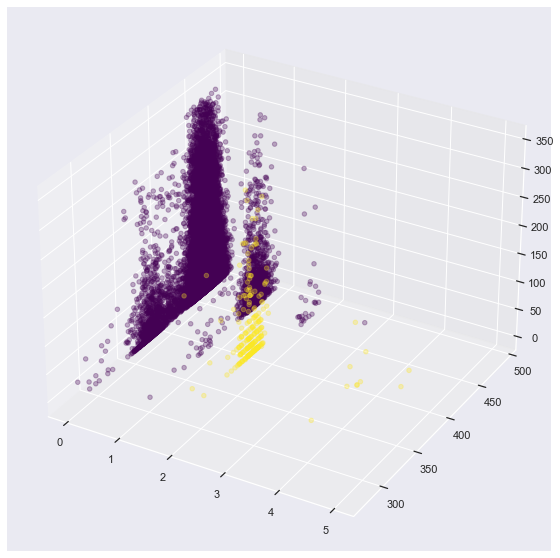

In [13]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(df['error2']+df['error3'],df['rotate_mean'],df['comp2_delay'],c=df['comp2'],cmap='viridis', alpha=0.3)

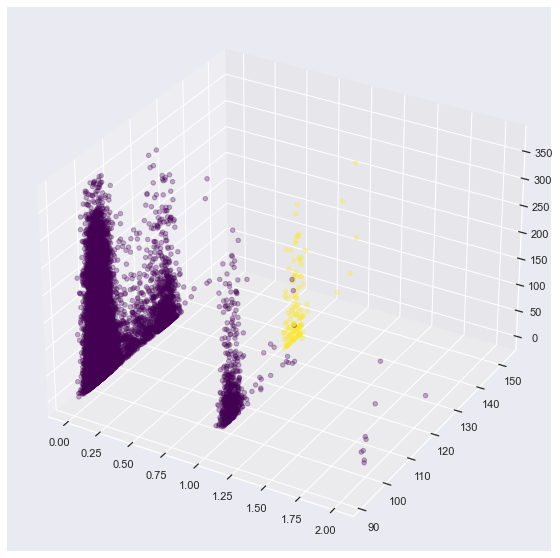

In [14]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(df['error4'],df['pressure_mean'],df['comp3_delay'],c=df['comp3'],cmap='viridis', alpha=0.3)

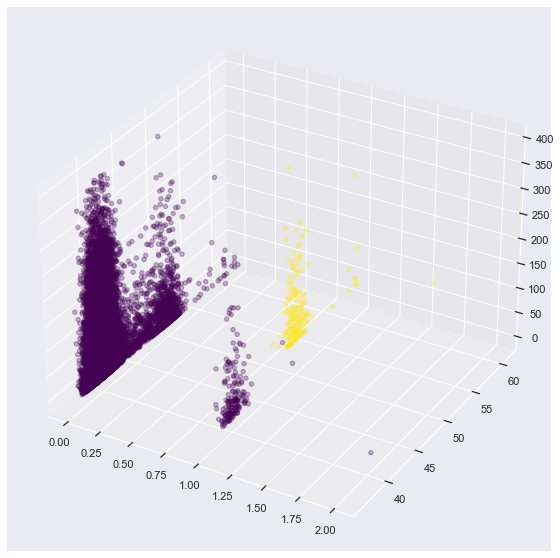

In [15]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(df['error5'],df['vibration_mean'],df['comp4_delay'],c=df['comp4'],cmap='viridis', alpha=0.3)

Les données sont très bien séparées sur ces graphiques en 3D: On peut implémenter un algorithme de plus proche voisins.

In [19]:
X = df[['error1','volt_mean','comp1_delay']]
y = df['comp1']

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.5, random_state=42)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

from sklearn.neighbors import KNeighborsClassifier

kneighbors = KNeighborsClassifier(3)
kneighbors.fit(X_train, Y_train)
y = kneighbors.predict(X_test)

import numpy as np
print(np.count_nonzero(y))
print(np.count_nonzero(_test))
print(np.count_nonzero(y-y_test))

NameError: name 'y_train' is not defined